#Description of the notebook

Students:
- Teka Kimbi Ntimanputu (10673197)
- William Stucchi (10661711)
- Lorenzo Veronese (10654901)

After achieving optimal success with the ConvNeXtBase model, the subsequent step involved experimenting with the ConvNeXtLarge model to broaden our analysis to a model with a larger number of paramenters.
New data augmentation techniques were introduced with respect to the previous models:

*   Random Cut
*   Mixup and Cut mix

Performances on the dataset of phase 1:  

*   accuracy=0.9200
*   precision=0.9688
*   recall=0.8158
*   F1=0.8857


Performances on the dataset of phase 2:

*   accuracy=0.8290
*   precision=0.7960
*   recall=0.7395
*   F1=0.7667





#FLAGS

List of flags to enable and disable some parts of the notebook

In [ ]:
#True to save the images on drive
CREATE_DATASET_FOLDER = False
#True to perform random cutout image augmentation
RANDOM_CUTOUT = False
#True to perform mix up and cut mix image augmentation
MIXUP_AND_CUTMIX = False


#Install keras CV

In [ ]:
!pip install keras_cv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.1/803.1 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 9.9 MB/s eta 0:00:00


# Import libraries

In [ ]:
#Connect to drive
from google.colab import drive

In [ ]:
from numpy import load
import numpy as np
from google.colab.patches import cv2_imshow
from PIL import Image, ImageOps
import os

In [ ]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [ ]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers
from keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import models
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.14.0


In [ ]:
# Import other libraries
import cv2
import keras_cv
from tensorflow.keras.applications.mobilenet import preprocess_input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import math

Using TensorFlow backend


In [ ]:
drive.mount('/gdrive')
%cd /gdrive/My Drive/ChallengeAN2DL/Homework1

Mounted at /gdrive
/gdrive/My Drive/ChallengeAN2DL/Homework1


#Loading dataset


In the following lines of code the dataset is loaded and divided into an image set and a label set

In [ ]:
#load data
data = load('public_data.npz', allow_pickle=True)
lst = data.files

In [ ]:
#Divide the dataset in image set and label set
img_set = data['data']
label_set = data['labels']


In [ ]:
#Inspect the shape and the type
print(data['data'][0].shape)
print(type(data['data'][0]))

(96, 96, 3)
<class 'numpy.ndarray'>


#Inspect Data

The dataset is displayed in order to perform an initial inspection on the data, allowing to underatand its content

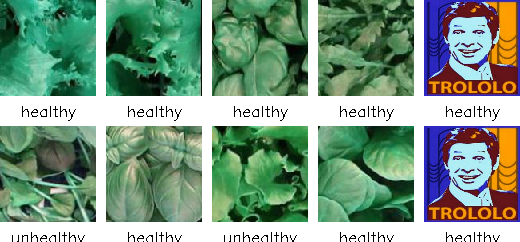

In [ ]:
# Calculate the canvas size based on image and label dimensions
num_images = len(img_set)
num_to_display = 10


vertical_spacing = 10
horizontal_spacing = 10


max_image_height = max(img.shape[0] for img in img_set)
image_width = img_set[0].shape[1]
label_height = 20
canvas_height = 2 * (max_image_height + label_height) + vertical_spacing
canvas_width = 5 * image_width + 4 * horizontal_spacing


canvas = np.ones((canvas_height, canvas_width, 3), dtype=np.uint8) * 255


random_indices = random.sample(range(num_images), num_to_display)

# Arrange and display the images and labels with spacing
for i, index in enumerate(random_indices):
    row = i // 5
    col = i % 5
    y_offset = row * (max_image_height + label_height + vertical_spacing)
    x_offset = col * (image_width + horizontal_spacing)


    img = img_set[index]
    canvas[y_offset:y_offset + img.shape[0], x_offset:x_offset + image_width, :] = img


    label_text = label_set[index]
    label_size, _ = cv2.getTextSize(label_text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    label_x = x_offset + (image_width - label_size[0]) // 2
    label_y = y_offset + img.shape[0] + label_height
    cv2.putText(canvas, label_text, (label_x, label_y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)

cv2_imshow(canvas)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Data Cleaning

Due to the presence of evident outliers within the dataset, a data cleaning operation was conducted to prepare the the data splitting phase and subsequent training phase.

## Shrek

In [ ]:
#Reference image 'shrek'
shrek = img_set[58]

# List to store the indexes of images to remove
indexes_to_remove = []

# Iterate through the image set to identify occurrences of 'shrek'
for i in range(0, len(img_set)):
    if np.array_equal(shrek, img_set[i]):
        indexes_to_remove.append(i)

print("Indexes to remove:", indexes_to_remove)
print("Number of indexes to remove:", len(indexes_to_remove))

Indexes to remove: [58, 95, 137, 138, 171, 207, 506, 571, 599, 622, 658, 692, 779, 827, 840, 880, 901, 974, 1028, 1265, 1268, 1280, 1333, 1443, 1466, 1483, 1528, 1554, 1594, 1651, 1806, 1866, 1938, 1977, 2022, 2081, 2090, 2261, 2311, 2328, 2380, 2435, 2451, 2453, 2515, 2663, 2665, 2675, 2727, 2734, 2736, 2755, 2779, 2800, 2830, 2864, 2866, 2913, 2937, 3033, 3055, 3105, 3144, 3155, 3286, 3410, 3488, 3572, 3583, 3666, 3688, 3770, 3801, 3802, 3806, 3811, 3862, 3885, 3927, 3931, 3946, 3988, 4097, 4118, 4144, 4150, 4282, 4368, 4475, 4476, 4507, 4694, 4740, 4779, 4857, 5082, 5121, 5171]
Number of indexes to remove: 98


In [ ]:
print("Length before removing Shrek: ", len(img_set))

#Remove the images and the labels related to the outliers
img_set = img_set[~np.isin(np.arange(len(img_set)), indexes_to_remove)]
label_set = label_set[~np.isin(np.arange(len(label_set)), indexes_to_remove)]

print("Length after removing Shrek: ", len(img_set))

Length before removing Shrek:  5200
Length after removing Shrek:  5102


## Trololo

In [ ]:
# Rreference image 'trololo'
trololo = img_set[332]  # Note: It is 332 AFTER removing 'Shrek'

#List to store the indexes of images to remove
indexes_to_remove = []

# Iterate through the image set to identify occurrences of 'trololo'
for i in range(0, len(img_set)):
    if np.array_equal(trololo, img_set[i]):
         indexes_to_remove.append(i)


print("Indexes to remove:", indexes_to_remove)
print("Number of indexes to remove:", len(indexes_to_remove))

Indexes to remove: [332, 406, 428, 480, 522, 689, 711, 713, 741, 770, 882, 944, 954, 971, 1025, 1045, 1046, 1082, 1130, 1153, 1171, 1172, 1361, 1514, 1580, 1601, 1660, 1667, 1722, 1727, 1729, 1797, 1871, 1906, 1947, 1954, 2113, 2154, 2155, 2161, 2308, 2385, 2443, 2452, 2519, 2536, 2548, 2551, 2628, 2743, 2776, 2784, 2832, 2871, 2989, 3025, 3046, 3311, 3370, 3385, 3423, 3629, 3669, 3728, 3745, 3759, 3818, 3821, 3826, 3869, 3883, 3907, 3967, 3973, 4017, 4223, 4227, 4229, 4323, 4413, 4466, 4514, 4527, 4627, 4643, 4673, 4743, 4754, 4765, 4788, 4802, 4808, 4812, 4832, 4953, 4985, 5046, 5068]
Number of indexes to remove: 98


In [ ]:
print("Length before removing Trololo: ", len(img_set))

#Remove the images and the labels related to the outliers
img_set = img_set[~np.isin(np.arange(len(img_set)), indexes_to_remove)]
label_set = label_set[~np.isin(np.arange(len(label_set)), indexes_to_remove)]


print("Length after removing Trololo: ", len(img_set))

Length before removing Trololo:  5102
Length after removing Trololo:  5004


# Distributions

The data distribution across different classes was visualized using a histogram

In [ ]:
# Unique classes in your label set
unique_classes = np.unique(label_set)
# Count the occurrences of each class
class_counts = [np.sum(label_set == c) for c in unique_classes]
# Number of bins,bar width, separation between bars and their position
n_bins = len(unique_classes)
bar_width = 0.4
bar_spacing = 0.2
x_positions = np.arange(len(unique_classes))
colors = ['green', 'brown']

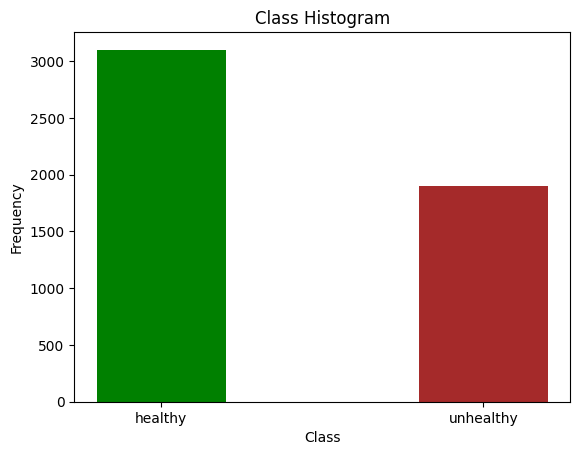

In [ ]:
# Plot the histogram with colored bars and adjusted spacing
plt.bar(x_positions, class_counts, width=bar_width, color=colors)
plt.xticks(x_positions, unique_classes)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Histogram')
plt.show()

#Create dataset folders


Using the previously loaded dataset, the images are stored in separate folders on the drive , categorized according to their recpective classes

In [ ]:
if CREATE_DATASET_FOLDER:
  # Mapping from label strings to numerical values
  labels_string_to_num = {'healthy': 0, 'unhealthy': 1}

  # Replace label strings with their corresponding numerical values
  for i in range(0, len(label_set)):
      label_set[i] = labels_string_to_num[label_set[i]]

  # Paths for saving images
  output_folder_0 = "data/healthy"
  output_folder_1 = "data/unhealthy"

  # Create the output folders if they don't exist
  os.makedirs(output_folder_0, exist_ok=True)
  os.makedirs(output_folder_1, exist_ok=True)

  # Iterate through the images and labels and store them according to their class
  for i, (img, label) in enumerate(zip(img_set, label_set)):
      img_pil = Image.fromarray(img.astype(np.uint8))

      if label == 0:
          output_folder = output_folder_0
      elif label == 1:
          output_folder = output_folder_1
      else:
          continue

      # Save the image
      img_filename = f"image_{i}.jpg"
      img_path = os.path.join(output_folder, img_filename)
      img_pil.save(img_path)

      print(f"Saved {img_filename} to {output_folder}")

Output streaming troncato alle ultime 5000 righe.
Saved image_4.jpg to data/unhealthy
Saved image_5.jpg to data/healthy
Saved image_6.jpg to data/unhealthy
Saved image_7.jpg to data/healthy
Saved image_8.jpg to data/healthy
Saved image_9.jpg to data/healthy
Saved image_10.jpg to data/healthy
Saved image_11.jpg to data/healthy
Saved image_12.jpg to data/healthy
Saved image_13.jpg to data/unhealthy
Saved image_14.jpg to data/unhealthy
Saved image_15.jpg to data/healthy
Saved image_16.jpg to data/unhealthy
Saved image_17.jpg to data/healthy
Saved image_18.jpg to data/healthy
Saved image_19.jpg to data/unhealthy
Saved image_20.jpg to data/healthy
Saved image_21.jpg to data/healthy
Saved image_22.jpg to data/healthy
Saved image_23.jpg to data/unhealthy
Saved image_24.jpg to data/healthy
Saved image_25.jpg to data/healthy
Saved image_26.jpg to data/unhealthy
Saved image_27.jpg to data/healthy
Saved image_28.jpg to data/healthy
Saved image_29.jpg to data/healthy
Saved image_30.jpg to data/unh

#Training and validation set

The dataset stored on drive is splitted into training and validation set

In [ ]:
# Define constants for dataset and image settings
VALIDATION_SPLIT = 0.15
BATCH_SIZE = 64
IMAGE_SIZE = (96, 96)
IMAGE_SHAPE = IMAGE_SIZE + (3,)
NUM_CLASSES = 2
DIR = 'data'

# Create a training dataset using image data from the specified directory
train_set = tf.keras.utils.image_dataset_from_directory(
    DIR,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=True,
    seed=seed,
    validation_split=VALIDATION_SPLIT,
    subset='training'
)

# Create a validation dataset using image data from the specified directory
val_set = tf.keras.utils.image_dataset_from_directory(
    DIR,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=True,
    seed=seed,
    validation_split=VALIDATION_SPLIT,
    subset='validation'
)


Found 5004 files belonging to 2 classes.
Using 4254 files for training.
Found 5004 files belonging to 2 classes.
Using 750 files for validation.


#Data Augmentation


Images are prepared to undergo to the data augmentation process in accordance with the recommended practices detailed in the [keras documentation](https://keras.io/guides/keras_cv/cut_mix_mix_up_and_rand_augment/).The images can possibly undergo to the following augmentation processes:


*   Random Cut
*   Random Mixup and Cutmix
*   Random Flip , Random Zoom and Random Rotation



##Preprocessing

In [ ]:
def fromUnitToFloat(img, label):
    # Convert image data type from unit8 to float32 for normalization
    img = tf.image.convert_image_dtype(img, tf.float32)
    return {"images": img, "labels": label}

In [ ]:
def prepare_input(inputs):
    # Cast the image data to the float32 data type for further processing
    images = tf.cast(inputs["images"], tf.float32)
    return images, inputs["labels"]

##Random cut

In [ ]:
def random_cut(data):
    random_cutout = keras_cv.layers.RandomCutout(0.5, 0.5)
    aug_data = random_cutout(data)
    return aug_data

In [ ]:
if RANDOM_CUTOUT:
  train_set = train_set.map(fromUnitToFloat).map(random_cut).map(prepare_input)

##CutMix and MixUp

In [ ]:
cut_mix = keras_cv.layers.CutMix()
mix_up = keras_cv.layers.MixUp()
probability = 0.7

def cut_mix_and_mix_up(data):
  if np.random.rand() > probability:
    samples = cut_mix(data, training=True)
  else:
    samples = mix_up(data, training=True)
    return samples

In [ ]:
if MIXUP_AND_CUTMIX:
  train_set = train_set.map(fromUnitToFloat).map(cut_mix_and_mix_up).map(prepare_input)

##RandomFlip,RandomRotation,RandomZoom

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal_and_vertical'),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(height_factor=-0.15)
],name='data_aug')

#Imbalanced dataset

To counteract imbalanced datasets, the approach of class weights is adopted,
wherein differents weights are allocated to classes determined by their frequencies within the dataset.

In [ ]:
# Paths to classes' folders
healthy_path = "data/healthy"
unhealthy_path = "data/unhealthy"

# List of all items in the two classes
healthy_items = os.listdir(healthy_path)
unhealthy_items = os.listdir(unhealthy_path)

num_healthy = len(healthy_items)
num_unhealthy = len(unhealthy_items)

print(f"There are {num_healthy} healthy and {num_unhealthy} unhealthy")


# Calculate the total number of samples
total = num_healthy + num_unhealthy


# Class weight for 0 (healthy)
weight_for_0 = (1 / num_healthy) * (total / 2.0)
# Class weight for 1 (unhealthy)
weight_for_1 = (1 / num_unhealthy) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0 (healthy): {:.2f}'.format(weight_for_0))
print('Weight for class 1 (unhealthy): {:.2f}'.format(weight_for_1))

There are 3101 healthy and 1903 unhealthy
Weight for class 0 (healthy): 0.81
Weight for class 1 (unhealthy): 1.31


#Transfer Learning

Pre-trained model to perform transfer learning

##Model

Instantiation of a ConvNeXtLarge model using TensorFlow's Keras library

In [ ]:
convLarge= tf.keras.applications.convnext.ConvNeXtLarge(
    input_shape=IMAGE_SHAPE,
    include_top=False,
    weights='imagenet',
    pooling = 'avg',

)

785596384/785596384 [==============================] - 11s 0us/step


All the layers of the network are freezed

In [ ]:
for layer in convLarge.layers:
  layer.trainable = False

Definition of the neural network model using TensorFlow's Keras API

In [ ]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=IMAGE_SHAPE, name="input_layer"),
    data_augmentation,
    tf.keras.layers.Lambda(tf.keras.applications.convnext.preprocess_input),
    convLarge,
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1024, activation='relu',kernel_initializer=tf.keras.initializers.HeUniform(seed)),
    tf.keras.layers.Dense(1024, activation='relu',kernel_initializer=tf.keras.initializers.HeUniform(seed)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax', kernel_initializer=tf.keras.initializers.GlorotUniform(seed), name='output_layer')
], name = "convNextLarge")

In [ ]:
model.summary()

Model: "convNextLarge"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_aug (Sequential)       (None, 96, 96, 3)         0         
                                                                 
 lambda (Lambda)             (None, 96, 96, 3)         0         
                                                                 
 convnext_large (Functional  (None, 1536)              196230336 
 )                                                               
                                                                 
 dropout (Dropout)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 1024)              1573888   
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                     

In [ ]:
base_learning_rate = 0.0001
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
    )


##Train

Train the model with early stopping

In [ ]:
callbacks = tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=25, restore_best_weights=True, mode='auto')
# Train the model
history = model.fit(
    x = train_set,
    epochs = 200,
    batch_size= BATCH_SIZE,
    validation_data = val_set,
    callbacks = [callbacks],
    class_weight=class_weight
).history

Epoch 1/200
67/67 [==============================] - 365s 4s/step - loss: 0.9378 - accuracy: 0.6112 - val_loss: 0.5154 - val_accuracy: 0.7427
Epoch 2/200
67/67 [==============================] - 34s 496ms/step - loss: 0.6787 - accuracy: 0.6928 - val_loss: 0.4327 - val_accuracy: 0.8173
Epoch 3/200
67/67 [==============================] - 33s 484ms/step - loss: 0.5726 - accuracy: 0.7398 - val_loss: 0.4266 - val_accuracy: 0.8013
Epoch 4/200
67/67 [==============================] - 33s 484ms/step - loss: 0.5433 - accuracy: 0.7433 - val_loss: 0.3981 - val_accuracy: 0.8120
Epoch 5/200
67/67 [==============================] - 33s 491ms/step - loss: 0.4973 - accuracy: 0.7753 - val_loss: 0.3933 - val_accuracy: 0.8333
Epoch 6/200
67/67 [==============================] - 33s 480ms/step - loss: 0.4732 - accuracy: 0.7861 - val_loss: 0.3827 - val_accuracy: 0.8333
Epoch 7/200
67/67 [==============================] - 38s 561ms/step - loss: 0.4630 - accuracy: 0.7797 - val_loss: 0.3866 - val_accuracy: 0

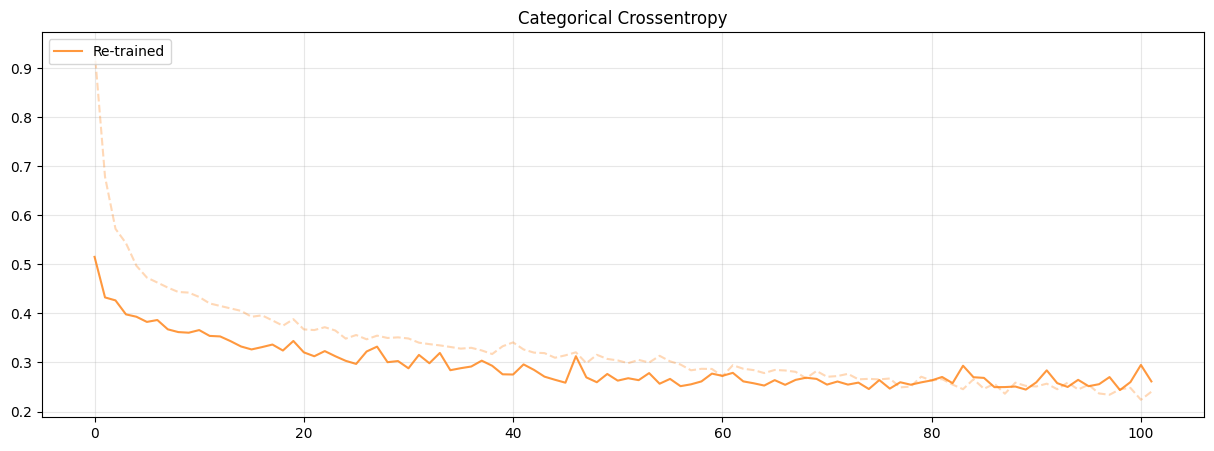

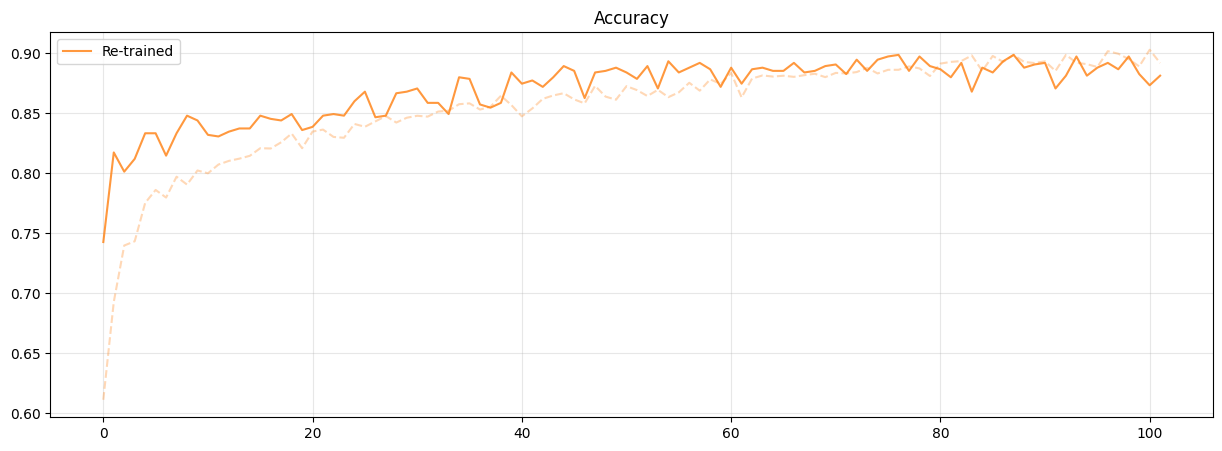

In [ ]:
# Plot the re-trained and the transfer learning ConvNextLarge training histories
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Re-trained', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Re-trained', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

Save the model (with day, hour, and minutes to avoid overlappings):

In [ ]:
from datetime import datetime

current_time = datetime.now()
current_hour = current_time.hour
current_minutes = current_time.minute
model.save("transfer_learning_ConvNextLarge")
del model

#Fine-Tuning

##Unfreeze layers

The model is re-loaded for the fine-tuning process, during which layers are unfrozen to compute new weights tailored to the new task requiremennts

In [ ]:
freezed_model = tfk.models.load_model("transfer_learning_ConvNextLarge")
#freezed_model = model
# learning rate for fine-tuning
freezed_learning_rate = 0.00005

freezed_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate, weight_decay=1e-5),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)
freezed_model.summary()

freezed_layers = freezed_model.get_layer(convLarge.name).layers
# Number of layers in the 'convN' layer of the freezed model
num_layers = len(freezed_model.get_layer(convLarge.name).layers)

Model: "convNextLarge"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_aug (Sequential)       (None, 96, 96, 3)         0         
                                                                 
 lambda (Lambda)             (None, 96, 96, 3)         0         
                                                                 
 convnext_large (Functional  (None, 1536)              196230336 
 )                                                               
                                                                 
 dropout (Dropout)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 1024)              1573888   
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                     

Starting from the final layers , the network is unfrozen.

*   num_unfreezed: count of layers to unfreeze
*   offset: defines the starting point for the unfreezing process





In [ ]:
# Freeze the entire 'convN' layer by setting it to non-trainable
freezed_model.get_layer(convLarge.name).trainable = True
num_unfreezed = 295
current_unfreezed = 0
offset = 0

# Iterate through the layers of the 'convN' layer in reverse order
for index in reversed(range(num_layers-offset)):
    layer = freezed_model.get_layer(convLarge.name).layers[index]

    # Check if the current layer can be unfrozen
    if current_unfreezed < num_unfreezed:
        current_unfreezed = current_unfreezed + 1
        layer.trainable = True
    else:
        layer.trainable = False

    # information about the layer's index, name, and trainable status
    print(index, layer.name, layer.trainable)

freezed_model.summary()


295 layer_normalization True
294 global_average_pooling2d True
293 tf.__operators__.add_35 True
292 convnext_large_stage_3_block_2_identity True
291 convnext_large_stage_3_block_2_layer_scale True
290 convnext_large_stage_3_block_2_pointwise_conv_2 True
289 convnext_large_stage_3_block_2_gelu True
288 convnext_large_stage_3_block_2_pointwise_conv_1 True
287 convnext_large_stage_3_block_2_layernorm True
286 convnext_large_stage_3_block_2_depthwise_conv True
285 tf.__operators__.add_34 True
284 convnext_large_stage_3_block_1_identity True
283 convnext_large_stage_3_block_1_layer_scale True
282 convnext_large_stage_3_block_1_pointwise_conv_2 True
281 convnext_large_stage_3_block_1_gelu True
280 convnext_large_stage_3_block_1_pointwise_conv_1 True
279 convnext_large_stage_3_block_1_layernorm True
278 convnext_large_stage_3_block_1_depthwise_conv True
277 tf.__operators__.add_33 True
276 convnext_large_stage_3_block_0_identity True
275 convnext_large_stage_3_block_0_layer_scale True
274 con

In [ ]:
unfreezed_callbacks = [
    tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True, mode='auto'),
]
# Train the model
history_unfreeze = freezed_model.fit(
    x = train_set,
    epochs = 200,
    initial_epoch = callbacks.best_epoch,
    batch_size= BATCH_SIZE,
    validation_data = val_set,
    callbacks = unfreezed_callbacks,
    class_weight=class_weight
).history

Epoch 77/200
67/67 [==============================] - 57s 567ms/step - loss: 0.2729 - accuracy: 0.8808 - val_loss: 0.2553 - val_accuracy: 0.8933
Epoch 78/200
67/67 [==============================] - 32s 478ms/step - loss: 0.2623 - accuracy: 0.8855 - val_loss: 0.2537 - val_accuracy: 0.8880
Epoch 79/200
67/67 [==============================] - 38s 556ms/step - loss: 0.2549 - accuracy: 0.8942 - val_loss: 0.2546 - val_accuracy: 0.8867
Epoch 80/200
67/67 [==============================] - 34s 494ms/step - loss: 0.2666 - accuracy: 0.8888 - val_loss: 0.2510 - val_accuracy: 0.9040
Epoch 81/200
67/67 [==============================] - 33s 478ms/step - loss: 0.2757 - accuracy: 0.8834 - val_loss: 0.2697 - val_accuracy: 0.8880
Epoch 82/200
67/67 [==============================] - 33s 481ms/step - loss: 0.2635 - accuracy: 0.8865 - val_loss: 0.2473 - val_accuracy: 0.8973
Epoch 83/200
67/67 [==============================] - 33s 481ms/step - loss: 0.2672 - accuracy: 0.8869 - val_loss: 0.2456 - val_ac

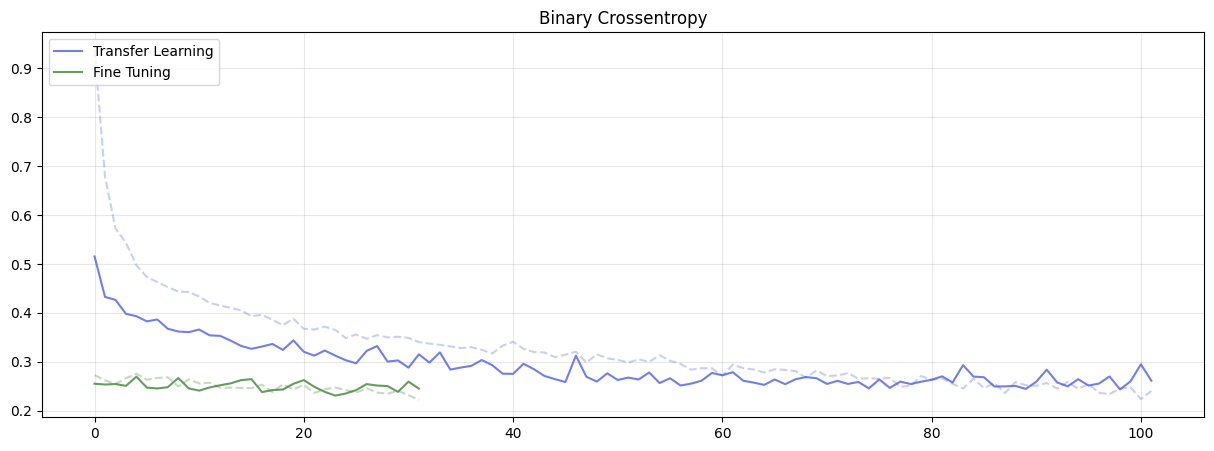

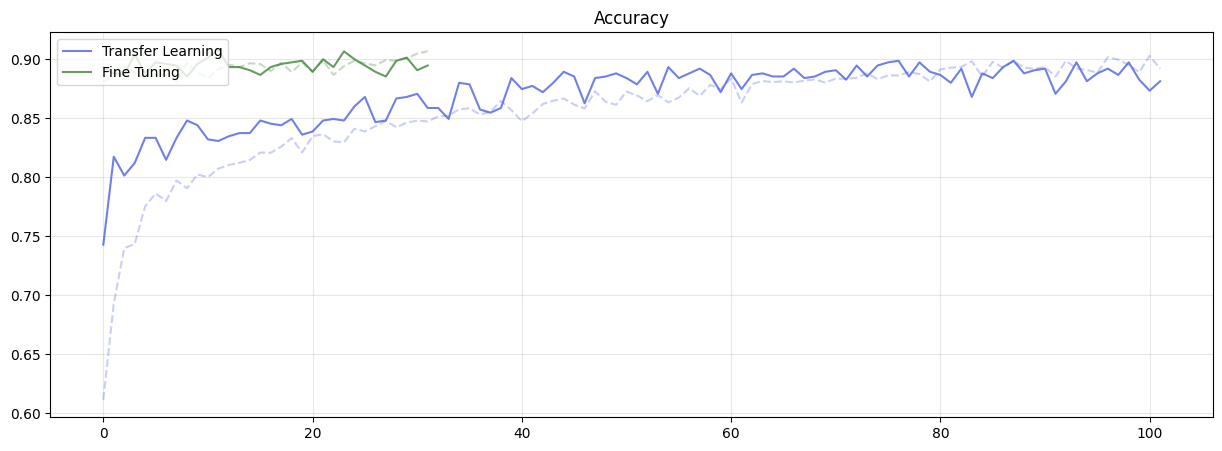

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history['val_loss'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.plot(history_unfreeze['loss'], alpha=.3, color='#408537', linestyle='--')
plt.plot(history_unfreeze['val_loss'], label='Fine Tuning', alpha=.8, color='#408537')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history['val_accuracy'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.plot(history_unfreeze['accuracy'], alpha=.3, color='#408537', linestyle='--')
plt.plot(history_unfreeze['val_accuracy'], label='Fine Tuning', alpha=.8, color='#408537')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

#Save model

In [ ]:
from datetime import datetime

current_time = datetime.now()
current_hour = current_time.hour
current_minutes = current_time.minute
freezed_model.save("fine_tuning_ConvNextLarge" + str(current_hour) + "_" + str(current_minutes))
del freezed_model
